# Proyecto 3 

- Maria Luisa Rodriguez 202121549
- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 202212868

## Instalacion e importacion de librerias

In [1]:
!pip install deap
!pip install memory_profiler

In [2]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
from haversine import haversine
import requests
import itertools
import matplotlib.pyplot as plt
import folium

import time
from memory_profiler import memory_usage

## Funciones de apoyo

In [3]:
def get_route_info(lat1, lon1, lat2, lon2):
    base_url = "http://router.project-osrm.org/route/v1/driving/"
    coordinates = f"{lon1},{lat1};{lon2},{lat2}"
    url = base_url + coordinates
    params = {
        "overview": "full",
        "geometries": "geojson"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if "routes" in data and data["routes"]:
            route = data["routes"][0]
            distance = route["distance"] / 1000.0
            geometry = route["geometry"]["coordinates"]
            polyline = [[coord[1], coord[0]] for coord in geometry]
            return distance, polyline
        else:
            raise Exception("No se encontró una ruta.")
    except Exception as e:
        print("Error al obtener ruta vía OSRM:", e)
        fallback_distance = haversine((lat1, lon1), (lat2, lon2))
        fallback_polyline = [[lat1, lon1], [lat2, lon2]]
        return fallback_distance, fallback_polyline


In [4]:
def calcular_distancias_y_geometrias(centros, clientes, get_route_info):
    all_nodes = list(centros.keys()) + list(clientes.keys())
    distancias = {}
    geometries = {}

    for i in all_nodes:
        for j in all_nodes:
            if i != j and not (i in centros and j in centros):
                # Obtener coordenadas de i
                if i in centros:
                    lat_i, lon_i = centros[i]["lat"], centros[i]["lon"]
                else:
                    lat_i, lon_i = clientes[i]["lat"], clientes[i]["lon"]
                
                # Obtener coordenadas de j
                if j in centros:
                    lat_j, lon_j = centros[j]["lat"], centros[j]["lon"]
                else:
                    lat_j, lon_j = clientes[j]["lat"], clientes[j]["lon"]

                # Obtener distancia y ruta
                distancia, polyline = get_route_info(lat_i, lon_i, lat_j, lon_j)
                distancias[(i, j)] = distancia
                geometries[(i, j)] = polyline

    return distancias, geometries


In [6]:
def calcular_distancias_osrm(centros, clientes):
    nodos = list(centros.keys()) + list(clientes.keys())
    idx = {n: i for i, n in enumerate(nodos)}

    coord_list = []
    for n in nodos:
        if n in centros:
            lat, lon = centros[n]['lat'], centros[n]['lon']
        else:
            lat, lon = clientes[n]['lat'], clientes[n]['lon']
        coord_list.append(f"{lon},{lat}")
    
    coords_str = ";".join(coord_list)

    url = f"http://router.project-osrm.org/table/v1/driving/{coords_str}?annotations=distance"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    mat = data["distances"]

    dist = {}
    for i, j in itertools.product(nodos, repeat=2):
        if i != j:
            dist[i, j] = mat[idx[i]][idx[j]] / 1000.0  # km
    
    return dist


In [7]:
def graficar_carga_por_vehiculo_ag(modelo_ag, nombre_figura="./resultados/carga_por_vehiculo.png"):
    rutas = modelo_ag.obtener_rutas()
    clientes = modelo_ag.clientes

    carga_por_vehiculo = {
        v: sum(clientes[c]["demanda"] for c in ruta)
        for v, ruta in rutas.items()
    }

    fig, ax = plt.subplots(figsize=(10, 6))
    vehiculos = list(carga_por_vehiculo.keys())
    cargas = list(carga_por_vehiculo.values())

    bars = ax.bar(vehiculos, cargas, color='skyblue')
    ax.set_title("Carga transportada por vehículo (AG)")
    ax.set_xlabel("Vehículo")
    ax.set_ylabel("Carga total (unidades)")
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(nombre_figura)
    plt.show()


In [8]:
def visualizar_rutas_folium_ag(rutas, centros, clientes, geometries, distancias, nombre_archivo="mapa_rutas_ag.html"):
    colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'darkgreen']
    color_map = {v: colores[i % len(colores)] for i, v in enumerate(rutas)}

    # Centro del mapa
    all_coords = [(centros[n]["lat"], centros[n]["lon"]) for n in centros] + \
                 [(clientes[n]["lat"], clientes[n]["lon"]) for n in clientes]
    mean_lat = sum(lat for lat, _ in all_coords) / len(all_coords)
    mean_lon = sum(lon for _, lon in all_coords) / len(all_coords)

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

    # Marcar centros
    for cd in centros:
        folium.Marker(
            location=[centros[cd]["lat"], centros[cd]["lon"]],
            popup=f"Centro {cd}",
            icon=folium.Icon(color='green', icon='home', prefix='fa')
        ).add_to(m)

    # Marcar clientes
    for c in clientes:
        folium.Marker(
            location=[clientes[c]["lat"], clientes[c]["lon"]],
            popup=f"Cliente {c}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)

    # Dibujar rutas usando geometries[(i, j)]
    for v, ruta in rutas.items():
        if not ruta:
            continue

        color = color_map[v]

        # Determinar CD inicio/fin más cercano (usando distancias ya calculadas)
        inicio = min(centros, key=lambda d: distancias.get((d, ruta[0]), float('inf')))
        final  = min(centros, key=lambda d: distancias.get((ruta[-1], d), float('inf')))
        full_ruta = [inicio] + ruta + [final]

        # Dibujar líneas entre cada par (i, j)
        for i, j in zip(full_ruta, full_ruta[1:]):
            geometry = geometries.get((i, j))
            if geometry:
                folium.PolyLine(
                    locations=geometry,
                    color=color,
                    weight=5,
                    opacity=0.8,
                    popup=f"Vehículo {v}: {i} → {j}"
                ).add_to(m)

    m.save(nombre_archivo)
    print(f"Mapa de rutas guardado en '{nombre_archivo}'")


## Carga de datos

### Caso Base

#### Vehiculos

In [8]:
vehicles1 = pd.read_csv('data/caso1/vehicles.csv')
vehicles1

,VehicleID,Capacity,Range
0,1,130,170
1,2,140,200
2,3,120,180
3,4,100,90
4,5,70,100
5,6,55,170
6,7,110,150
7,8,114,140


#### Clientes

In [9]:
clients1 = pd.read_csv('data/caso1/clients.csv')
clients1

,ClientID,LocationID,Demand,Longitude,Latitude
0,1,2,13,-74.098938,4.597954
1,2,3,15,-74.075571,4.687821
2,3,4,12,-74.107085,4.709494
3,4,5,15,-74.097280,4.605029
4,5,6,20,-74.164641,4.648464
5,6,7,17,-74.120838,4.662137
6,7,8,17,-74.022131,4.697499
7,8,9,20,-74.172075,4.649417
8,9,10,20,-74.156153,4.606311
9,10,11,15,-74.090411,4.557380


#### Depositos

In [10]:
depots1 = pd.read_csv('data/caso1/depots.csv')
depots1 = depots1.rename(columns={'DepotID': 'Longitude', 'Longitude': 'Latitude', 'Latitude': 'Delted', 'LocationID': 'DepotID'})
depots1 = depots1.drop(columns=['Delted'])
depots1['Capacity'] = 4000 
depots1

,DepotID,Longitude,Latitude,Capacity
0,1,-74.153536,4.743359,4000


### Caso 2

#### Vehiculos

In [11]:
vehicles2 = pd.read_csv('data/caso2/vehicles.csv')
vehicles2

,VehicleID,Capacity,Range
0,1,131.921140,145.852071
1,2,108.435620,1304.605971
2,3,91.504255,953.172609
3,4,32.896064,17.302304
4,5,22.652628,16.627680
5,6,22.682912,13.602811


#### Clientes

In [12]:
clients2 = pd.read_csv("data/caso2/clients.csv")
clients2

,ClientID,LocationID,Demand,Longitude,Latitude
0,1,13,12,-74.196992,4.632553
1,2,14,15,-74.155037,4.601328
2,3,15,15,-74.101787,4.732421
3,4,16,6,-74.194862,4.638612
4,5,17,5,-74.110272,4.727692
5,6,18,11,-74.152289,4.665003
6,7,19,12,-74.032411,4.677102
7,8,20,10,-74.062476,4.707007
8,9,21,15,-74.098042,4.636075


#### Depositos

In [13]:
depots2 = pd.read_csv("data/caso2/depots.csv")
depots2

,DepotID,LocationID,Longitude,Latitude,Capacity
0,1,1,-74.081242,4.750212,8
1,2,2,-74.109934,4.536383,10
2,3,3,-74.038548,4.792926,0
3,4,4,-74.067069,4.721678,4
4,5,5,-74.138263,4.607707,28
5,6,6,-74.124002,4.650463,3
6,7,7,-74.095619,4.621912,0
7,8,8,-74.109756,4.678961,10
8,9,9,-74.095472,4.735973,43
9,10,10,-74.109916,4.550641,1


### Caso 3 (Heavy)

#### Vehiculos

In [14]:
vehicles3 = pd.read_csv("data/caso3/vehicles.csv")
vehicles3

,VehicleID,Capacity,Range
0,1,132,146
1,2,136,196
2,3,115,143
3,4,158,174
4,5,109,167
5,6,109,137
6,7,126,93
7,8,79,134
8,9,96,160
9,10,99,108


#### Clientes

In [15]:
clients3 = pd.read_csv("data/caso3/clients.csv")
clients3

,ClientID,locationID,Demand,Longitude,Latitude
0,1,12,12,-74.150806,4.679769
1,2,13,12,-74.017996,4.733831
2,3,14,12,-74.143655,4.620928
3,4,15,12,-74.034583,4.733074
4,5,16,12,-74.055887,4.820900
...,...,...,...,...,...
85,86,97,12,-74.075137,4.547407
86,87,98,10,-74.162648,4.659240
87,88,99,12,-74.147008,4.564126
88,89,100,12,-74.073188,4.579649


#### Depositos

In [16]:
depots3 = pd.read_csv("data/caso3/depots.csv")
depots3

,DepotID,LocationID,Longitude,Latitude,Capacity
0,1,1,-74.081242,4.750212,11
1,2,2,-74.109934,4.536383,90
2,3,3,-74.038548,4.792926,130
3,4,4,-74.067069,4.721678,145
4,5,5,-74.138263,4.607707,260
5,6,6,-74.124002,4.650463,180
6,7,7,-74.095619,4.621912,720
7,8,8,-74.109756,4.678961,55
8,9,9,-74.095472,4.735973,70
9,10,10,-74.109916,4.550641,75


## Procesamiento de datos

### Caso Base

In [17]:
centros1 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots1.iterrows()
}

centros1


{'CD1': {'lat': np.float64(4.743359),
  'lon': np.float64(-74.153536),
  'cap': np.float64(4000.0)}}

In [18]:
vehiculos1 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles1.iterrows()
}

vehiculos1


{'V1': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V2': {'cap': np.int64(140), 'rango': np.int64(200)},
 'V3': {'cap': np.int64(120), 'rango': np.int64(180)},
 'V4': {'cap': np.int64(100), 'rango': np.int64(90)},
 'V5': {'cap': np.int64(70), 'rango': np.int64(100)},
 'V6': {'cap': np.int64(55), 'rango': np.int64(170)},
 'V7': {'cap': np.int64(110), 'rango': np.int64(150)},
 'V8': {'cap': np.int64(114), 'rango': np.int64(140)}}

In [19]:
clientes1 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients1.iterrows()
}

clientes1

{'C1': {'demanda': np.float64(13.0),
  'lat': np.float64(4.59795431125545),
  'lon': np.float64(-74.09893796560621)},
 'C2': {'demanda': np.float64(15.0),
  'lat': np.float64(4.687820646838871),
  'lon': np.float64(-74.07557103763986)},
 'C3': {'demanda': np.float64(12.0),
  'lat': np.float64(4.70949446000624),
  'lon': np.float64(-74.10708524062704)},
 'C4': {'demanda': np.float64(15.0),
  'lat': np.float64(4.605029068682624),
  'lon': np.float64(-74.09727965657427)},
 'C5': {'demanda': np.float64(20.0),
  'lat': np.float64(4.648463876533332),
  'lon': np.float64(-74.16464148202755)},
 'C6': {'demanda': np.float64(17.0),
  'lat': np.float64(4.662137416953968),
  'lon': np.float64(-74.12083799988112)},
 'C7': {'demanda': np.float64(17.0),
  'lat': np.float64(4.697499030379109),
  'lon': np.float64(-74.02213076607309)},
 'C8': {'demanda': np.float64(20.0),
  'lat': np.float64(4.649416884236942),
  'lon': np.float64(-74.17207549744595)},
 'C9': {'demanda': np.float64(20.0),
  'lat': np.f

### Caso 2

In [20]:
centros2 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots2.iterrows()
}

centros2


{'CD1': {'lat': np.float64(4.75021190869025),
  'lon': np.float64(-74.08124218159384),
  'cap': np.float64(8.0)},
 'CD2': {'lat': np.float64(4.5363832206427785),
  'lon': np.float64(-74.10993358606953),
  'cap': np.float64(10.0)},
 'CD3': {'lat': np.float64(4.792925960208614),
  'lon': np.float64(-74.03854814565923),
  'cap': np.float64(0.0)},
 'CD4': {'lat': np.float64(4.72167778077445),
  'lon': np.float64(-74.06706883098641),
  'cap': np.float64(4.0)},
 'CD5': {'lat': np.float64(4.607707046760958),
  'lon': np.float64(-74.13826337931849),
  'cap': np.float64(28.0)},
 'CD6': {'lat': np.float64(4.650463053612691),
  'lon': np.float64(-74.12400186370824),
  'cap': np.float64(3.0)},
 'CD7': {'lat': np.float64(4.621911772492814),
  'lon': np.float64(-74.09561875464892),
  'cap': np.float64(0.0)},
 'CD8': {'lat': np.float64(4.678960680833056),
  'lon': np.float64(-74.10975623736951),
  'cap': np.float64(10.0)},
 'CD9': {'lat': np.float64(4.735973062153282),
  'lon': np.float64(-74.0954723

In [21]:
vehiculos2 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles2.iterrows()
}

vehiculos2


{'V1': {'cap': np.float64(131.9211396722696),
  'rango': np.float64(145.85207096486445)},
 'V2': {'cap': np.float64(108.4356199315333),
  'rango': np.float64(1304.605971281605)},
 'V3': {'cap': np.float64(91.50425520531196),
  'rango': np.float64(953.172608610164)},
 'V4': {'cap': np.float64(32.896064077536955),
  'rango': np.float64(17.302304187458727)},
 'V5': {'cap': np.float64(22.65262807032524),
  'rango': np.float64(16.627680130757895)},
 'V6': {'cap': np.float64(22.682911535937688),
  'rango': np.float64(13.602810739289229)}}

In [22]:
clientes2 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients2.iterrows()
}

clientes2

{'C1': {'demanda': np.float64(12.0),
  'lat': np.float64(4.632552840424734),
  'lon': np.float64(-74.19699184741948)},
 'C2': {'demanda': np.float64(15.0),
  'lat': np.float64(4.601328214582278),
  'lon': np.float64(-74.15503659129905)},
 'C3': {'demanda': np.float64(15.0),
  'lat': np.float64(4.732421040989568),
  'lon': np.float64(-74.10178731827096)},
 'C4': {'demanda': np.float64(6.0),
  'lat': np.float64(4.638612189685843),
  'lon': np.float64(-74.19486224157397)},
 'C5': {'demanda': np.float64(5.0),
  'lat': np.float64(4.727691608175209),
  'lon': np.float64(-74.11027242131048)},
 'C6': {'demanda': np.float64(11.0),
  'lat': np.float64(4.665002925306577),
  'lon': np.float64(-74.15228946899238)},
 'C7': {'demanda': np.float64(12.0),
  'lat': np.float64(4.6771016997028205),
  'lon': np.float64(-74.03241075805882)},
 'C8': {'demanda': np.float64(10.0),
  'lat': np.float64(4.707007012114083),
  'lon': np.float64(-74.0624758742746)},
 'C9': {'demanda': np.float64(15.0),
  'lat': np.f

### Caso 3

In [23]:
centros3 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots3.iterrows()
}

centros3

{'CD1': {'lat': np.float64(4.75021190869025),
  'lon': np.float64(-74.08124218159384),
  'cap': np.float64(11.0)},
 'CD2': {'lat': np.float64(4.5363832206427785),
  'lon': np.float64(-74.10993358606953),
  'cap': np.float64(90.0)},
 'CD3': {'lat': np.float64(4.792925960208614),
  'lon': np.float64(-74.03854814565923),
  'cap': np.float64(130.0)},
 'CD4': {'lat': np.float64(4.72167778077445),
  'lon': np.float64(-74.06706883098641),
  'cap': np.float64(145.0)},
 'CD5': {'lat': np.float64(4.607707046760958),
  'lon': np.float64(-74.13826337931849),
  'cap': np.float64(260.0)},
 'CD6': {'lat': np.float64(4.650463053612691),
  'lon': np.float64(-74.12400186370824),
  'cap': np.float64(180.0)},
 'CD7': {'lat': np.float64(4.621911772492814),
  'lon': np.float64(-74.09561875464892),
  'cap': np.float64(720.0)},
 'CD8': {'lat': np.float64(4.678960680833056),
  'lon': np.float64(-74.10975623736951),
  'cap': np.float64(55.0)},
 'CD9': {'lat': np.float64(4.735973062153282),
  'lon': np.float64(-

In [24]:
vehiculos3 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles3.iterrows()
}

vehiculos3

{'V1': {'cap': np.int64(132), 'rango': np.int64(146)},
 'V2': {'cap': np.int64(136), 'rango': np.int64(196)},
 'V3': {'cap': np.int64(115), 'rango': np.int64(143)},
 'V4': {'cap': np.int64(158), 'rango': np.int64(174)},
 'V5': {'cap': np.int64(109), 'rango': np.int64(167)},
 'V6': {'cap': np.int64(109), 'rango': np.int64(137)},
 'V7': {'cap': np.int64(126), 'rango': np.int64(93)},
 'V8': {'cap': np.int64(79), 'rango': np.int64(134)},
 'V9': {'cap': np.int64(96), 'rango': np.int64(160)},
 'V10': {'cap': np.int64(99), 'rango': np.int64(108)},
 'V11': {'cap': np.int64(125), 'rango': np.int64(955)},
 'V12': {'cap': np.int64(98), 'rango': np.int64(716)},
 'V13': {'cap': np.int64(86), 'rango': np.int64(1023)},
 'V14': {'cap': np.int64(74), 'rango': np.int64(1076)},
 'V15': {'cap': np.int64(85), 'rango': np.int64(942)},
 'V16': {'cap': np.int64(22), 'rango': np.int64(21)},
 'V17': {'cap': np.int64(25), 'rango': np.int64(12)},
 'V18': {'cap': np.int64(30), 'rango': np.int64(12)},
 'V19': {'cap

In [25]:
clientes3 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients3.iterrows()
}

clientes3

{'C1': {'demanda': np.float64(12.0),
  'lat': np.float64(4.679769454542633),
  'lon': np.float64(-74.15080587752655)},
 'C2': {'demanda': np.float64(12.0),
  'lat': np.float64(4.733830991590818),
  'lon': np.float64(-74.01799606682779)},
 'C3': {'demanda': np.float64(12.0),
  'lat': np.float64(4.620928444870193),
  'lon': np.float64(-74.14365528529937)},
 'C4': {'demanda': np.float64(12.0),
  'lat': np.float64(4.7330740665555),
  'lon': np.float64(-74.03458280137461)},
 'C5': {'demanda': np.float64(12.0),
  'lat': np.float64(4.820900231096688),
  'lon': np.float64(-74.05588712830665)},
 'C6': {'demanda': np.float64(12.0),
  'lat': np.float64(4.779275206620083),
  'lon': np.float64(-74.04633863054056)},
 'C7': {'demanda': np.float64(12.0),
  'lat': np.float64(4.723527744298546),
  'lon': np.float64(-74.06470768583738)},
 'C8': {'demanda': np.float64(12.0),
  'lat': np.float64(4.551786739961474),
  'lon': np.float64(-74.16228381122208)},
 'C9': {'demanda': np.float64(12.0),
  'lat': np.f

## Algoritmo Genetico

In [26]:
class ModeloRuteoAG:
    def __init__(self, centros, clientes, vehiculos, parametros, distancias):
        self.centros = centros
        self.clientes = clientes
        self.vehiculos = vehiculos
        self.parametros = parametros
        self.distancias = distancias
        self.best_solution = None
        self.best_cost = None

        self.C = list(clientes.keys())
        self.D = list(centros.keys())
        self.V = list(vehiculos.keys())

        self.id_to_idx = {cid: i for i, cid in enumerate(self.C)}
        self.idx_to_id = {i: cid for cid, i in self.id_to_idx.items()}

        self._init_deap()

    def _init_deap(self):
        if not hasattr(creator, "FitnessMin"):
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        if not hasattr(creator, "Individual"):
            creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()
        self.toolbox.register("individual", self._generar_individuo)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self._evaluar)
        self.toolbox.register("mate", tools.cxPartialyMatched)
        self.toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def _generar_individuo(self):
        idxs = list(range(len(self.C)))
        random.shuffle(idxs)
        separadores = [-1] * (len(self.V) - 1)
        cromosoma = idxs + separadores
        random.shuffle(cromosoma)
        return creator.Individual(cromosoma)

    def _decodificar(self, ind):
        rutas = []
        actual = []
        for gen in ind:
            if gen == -1:
                if actual:
                    rutas.append([self.idx_to_id[i] for i in actual])
                    actual = []
            else:
                actual.append(gen)
        if actual:
            rutas.append([self.idx_to_id[i] for i in actual])
        while len(rutas) < len(self.V):
            rutas.append([])
        return dict(zip(self.V, rutas))

    def _evaluar(self, ind):
        rutas = self._decodificar(ind)
        costo_total = 0
        penalizacion = 0
        demanda_por_cd = {d: 0 for d in self.D}

        for v in self.V:
            ruta = rutas[v]
            if not ruta:
                continue

            # Centro más cercano como origen/destino
            cd_inicio = min(self.D, key=lambda d: self.distancias.get((d, ruta[0]), float('inf')))
            cd_final = min(self.D, key=lambda d: self.distancias.get((ruta[-1], d), float('inf')))
            full_ruta = [cd_inicio] + ruta + [cd_final]

            # Sumar demanda al centro de distribución
            demanda_total = sum(self.clientes[c]["demanda"] for c in ruta)
            demanda_por_cd[cd_inicio] += demanda_total

            # Calcular distancia total
            dist_ruta = sum(self.distancias.get((full_ruta[i], full_ruta[i+1]), 1e6)
                            for i in range(len(full_ruta)-1))

            costo_km = self.parametros["Ft"] + self.parametros["Cm"] + self.parametros["RC"] * self.parametros["Pf"]
            costo_total += dist_ruta * costo_km

            # Penalizaciones por restricciones de vehículo
            if dist_ruta > self.vehiculos[v]["rango"]:
                penalizacion += 1e6
            if demanda_total > self.vehiculos[v]["cap"]:
                penalizacion += 1e6

            # Subtours: clientes repetidos en su propia ruta
            if len(set(ruta)) < len(ruta):
                penalizacion += 1e6

        # Penalización por exceso de capacidad en CD
        for d in self.D:
            if demanda_por_cd[d] > self.centros[d]["cap"]:
                penalizacion += 1e6

        # Penalizaciones globales
        visitados = [c for ruta in rutas.values() for c in ruta]
        penalizacion += 1e6 * (len(set(self.C)) - len(set(visitados)))  # no atendidos
        penalizacion += 1e6 * (len(visitados) - len(set(visitados)))   # duplicados

        return costo_total + penalizacion,

    def resolver(self, n_generaciones=300, tam_poblacion=100, verbose=True):
        pop = self.toolbox.population(n=tam_poblacion)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)

        algorithms.eaSimple(pop, self.toolbox, cxpb=0.8, mutpb=0.2, ngen=n_generaciones,
                            stats=stats, halloffame=hof, verbose=verbose)

        self.best_solution = self._decodificar(hof[0])
        self.best_cost = self._evaluar(hof[0])[0]

    def obtener_rutas(self):
        return self.best_solution

    def valor_funcion_objetivo(self):
        return self.best_cost

In [27]:
parametros = {"Pf": 15000, "Ft": 5000, "Cm": 700, "RC": 0.35}

### Caso Base

In [28]:
distancias1, geometries1 = calcular_distancias_y_geometrias(centros1, clientes1, get_route_info)

In [56]:
modelo_ag = ModeloRuteoAG(centros1, clientes1, vehiculos1, parametros, distancias1)

start_time1 = time.time()
mem_usage1, result = memory_usage(
    (modelo_ag.resolver, (100, 80)), retval=True, interval=0.1, max_usage=True
)
end_time1 = time.time()

print("Tiempo de ejecución:", end_time1 - start_time1, "segundos")
print("Uso máximo de memoria:", mem_usage1, "MiB")

for v, ruta in modelo_ag.obtener_rutas().items():
    print(f"{v}: {ruta}")


gen	nevals	min        	avg        
0  	80    	5.68955e+06	8.09585e+06
1  	68    	5.85715e+06	1.44903e+08
2  	70    	6.09593e+06	5.55531e+08
3  	71    	5.57913e+06	1.44776e+08
4  	72    	5.56282e+06	2.81628e+08
5  	72    	5.43498e+06	1.44876e+08
6  	71    	5.42008e+06	1.44558e+08
7  	71    	5.42008e+06	2.81456e+08
8  	61    	5.43498e+06	2.81345e+08
9  	70    	5.48546e+06	1.44301e+08
10 	70    	5.31907e+06	2.80983e+08
11 	66    	5.62627e+06	2.81516e+08
12 	72    	5.36999e+06	7.39392e+06
13 	68    	5.36999e+06	7.21215e+06
14 	72    	5.04152e+06	2.80959e+08
15 	66    	5.00815e+06	2.8118e+08 
16 	70    	5.00339e+06	7.52807e+06
17 	65    	4.82074e+06	7.04061e+06
18 	65    	5.05347e+06	1.43871e+08
19 	54    	4.84478e+06	1.43586e+08
20 	73    	4.68447e+06	6.89479e+06
21 	65    	4.96605e+06	1.43874e+08
22 	64    	4.93258e+06	6.4814e+06 
23 	74    	4.88166e+06	6.67561e+06
24 	63    	4.69927e+06	1.43473e+08
25 	67    	4.82934e+06	6.53337e+06
26 	72    	4.68624e+06	6.22485e+06
27 	69    	4.51359e+

In [58]:
visualizar_rutas_folium_ag(modelo_ag.obtener_rutas(), centros1, clientes1, geometries1, distancias1, nombre_archivo="resultados/mapa_rutas_ag_caso1.html")

Mapa de rutas guardado en 'resultados/mapa_rutas_ag_caso1.html'


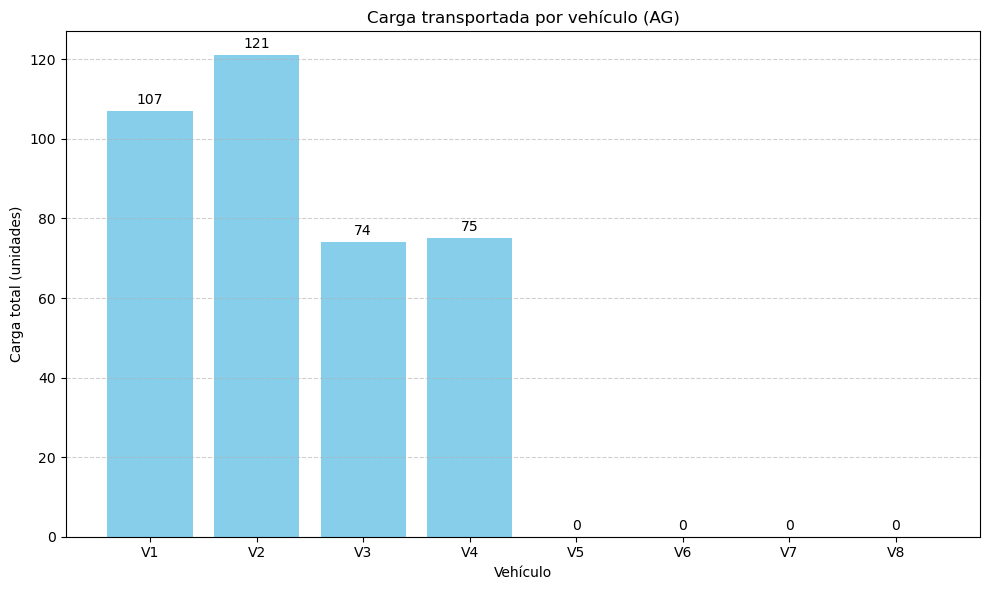

In [57]:
graficar_carga_por_vehiculo_ag(modelo_ag, nombre_figura="resultados/carga_por_vehiculo_ag_caso1.png")

### Caso 2

In [32]:
distancias2, geometries2 = calcular_distancias_y_geometrias(centros2, clientes2, get_route_info)

In [59]:
modelo_ag_2 = ModeloRuteoAG(centros2, clientes2, vehiculos2, parametros, distancias2)


start_time2 = time.time()
mem_usage2, result = memory_usage(
    (modelo_ag_2.resolver, (100, 80)), retval=True, interval=0.1, max_usage=True
)
end_time2 = time.time()

print("Tiempo de ejecución:", end_time2 - start_time2, "segundos")
print("Uso máximo de memoria:", mem_usage2, "MiB")

print("Costo total:", modelo_ag_2.valor_funcion_objetivo())

for v, ruta in modelo_ag_2.obtener_rutas().items():
    print(f"{v}: {ruta}")


gen	nevals	min        	avg        
0  	80    	2.36059e+06	4.64211e+06
1  	68    	2.13138e+06	1.41026e+08
2  	66    	2.13138e+06	1.41037e+08
3  	70    	2.18567e+06	1.40671e+08
4  	71    	2.05926e+06	2.77544e+08
5  	75    	2.07041e+06	2.77652e+08
6  	66    	2.07041e+06	3.77444e+06
7  	70    	2.07041e+06	1.40647e+08
8  	72    	2.15393e+06	2.77627e+08
9  	66    	2.07041e+06	3.50796e+06
10 	72    	2.07041e+06	3.76533e+06
11 	66    	2.15567e+06	3.71849e+06
12 	59    	2.15567e+06	1.40545e+08
13 	65    	2.09484e+06	4.14143e+08
14 	65    	1.96325e+06	1.40073e+08
15 	64    	1.96325e+06	1.39654e+08
16 	76    	1.96325e+06	2.69871e+06
17 	69    	1.92989e+06	2.49311e+06
18 	73    	1.92989e+06	1.39177e+08
19 	62    	1.92989e+06	1.39157e+08
20 	68    	1.92989e+06	2.26512e+06
21 	70    	1.92989e+06	2.07369e+06
22 	71    	1.92989e+06	1.99452e+06
23 	66    	1.92989e+06	2.01352e+06
24 	70    	1.92989e+06	2.02313e+06
25 	66    	1.92989e+06	2.01418e+06
26 	71    	1.92989e+06	1.95051e+06
27 	63    	1.92989e+

In [60]:
visualizar_rutas_folium_ag(modelo_ag_2.obtener_rutas(), centros2, clientes2, geometries2, distancias2, nombre_archivo="resultados/mapa_rutas_ag_caso2.html")

Mapa de rutas guardado en 'resultados/mapa_rutas_ag_caso2.html'


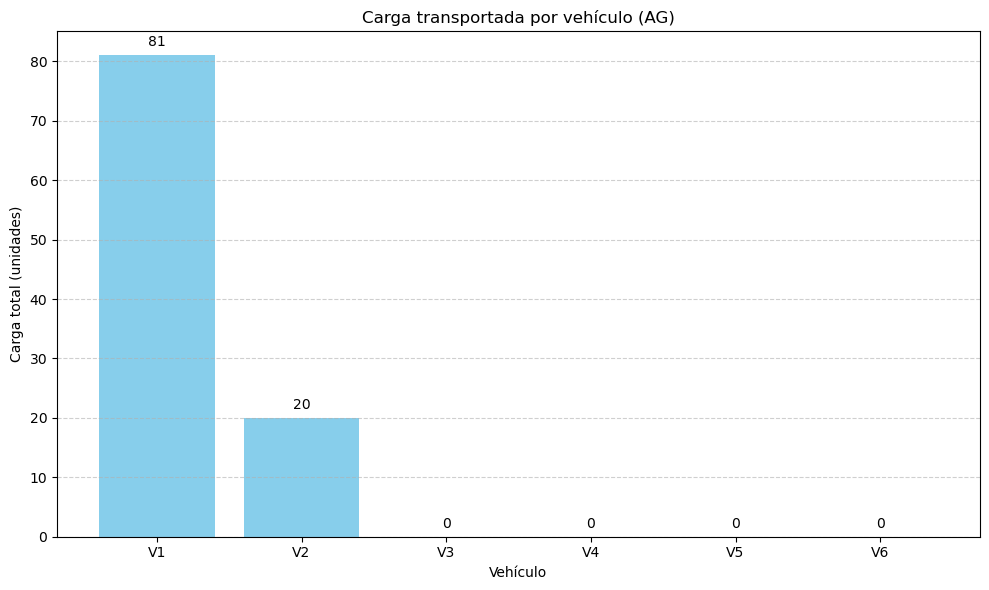

In [61]:
graficar_carga_por_vehiculo_ag(modelo_ag_2, nombre_figura="resultados/carga_por_vehiculo_ag_caso2.png")

### Caso 3

In [36]:
distancias3, geometries3 = calcular_distancias_y_geometrias(centros3, clientes3, get_route_info)

Error al obtener ruta vía OSRM: HTTPConnectionPool(host='router.project-osrm.org', port=80): Max retries exceeded with url: /route/v1/driving/-74.18525848230523,4.623575730110324;-74.17871803779973,4.586764170616499?overview=full&geometries=geojson (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001AD01B6D4F0>: Failed to establish a new connection: [WinError 10060] Se produjo un error durante el intento de conexión ya que la parte conectada no respondió adecuadamente tras un periodo de tiempo, o bien se produjo un error en la conexión establecida ya que el host conectado no ha podido responder'))
Error al obtener ruta vía OSRM: HTTPConnectionPool(host='router.project-osrm.org', port=80): Max retries exceeded with url: /route/v1/driving/-74.18525848230523,4.623575730110324;-74.02905876431227,4.735597416649075?overview=full&geometries=geojson (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000001AD01B6D2B0>: Failed to resolv

In [62]:
modelo_ag_3 = ModeloRuteoAG(centros3, clientes3, vehiculos3, parametros, distancias3)

start_time3 = time.time()
mem_usage3, result = memory_usage(
    (modelo_ag_3.resolver, (100, 80)), retval=True, interval=0.1, max_usage=True
)
end_time3 = time.time()

print("Tiempo de ejecución:", end_time3 - start_time3, "segundos")
print("Uso máximo de memoria:", mem_usage3, "MiB")

print("Costo total:", modelo_ag_3.valor_funcion_objetivo())

for v, ruta in modelo_ag_3.obtener_rutas().items():
    print(f"{v}: {ruta}")


gen	nevals	min       	avg        
0  	80    	1.7473e+07	2.59994e+07
1  	69    	1.92876e+07	4.35933e+08
2  	64    	2.00542e+07	2.43502e+07
3  	65    	1.94563e+07	4.34746e+08
4  	65    	1.80195e+07	2.35915e+07
5  	69    	1.7211e+07 	1.60059e+08
6  	70    	1.81729e+07	7.07609e+08
7  	64    	1.58231e+07	1.59333e+08
8  	68    	1.58231e+07	2.95909e+08
9  	68    	1.49568e+07	2.21799e+07
10 	62    	1.49568e+07	2.07152e+07
11 	68    	1.52147e+07	2.16964e+07
12 	73    	1.52147e+07	1.59172e+08
13 	64    	1.52147e+07	1.58075e+08
14 	64    	1.52147e+07	2.1236e+07 
15 	66    	1.44613e+07	2.94683e+08
16 	70    	1.52147e+07	5.67576e+08
17 	66    	1.39617e+07	1.55788e+08
18 	66    	1.49101e+07	5.66456e+08
19 	62    	1.46335e+07	1.55389e+08
20 	71    	1.44842e+07	1.80396e+07
21 	61    	1.41592e+07	1.72499e+07
22 	64    	1.38304e+07	1.69037e+07
23 	62    	1.38388e+07	1.61197e+07
24 	65    	1.37878e+07	1.56441e+07
25 	70    	1.37609e+07	1.56264e+07
26 	66    	1.36393e+07	1.56744e+07
27 	72    	1.35474e+07

In [63]:
visualizar_rutas_folium_ag(modelo_ag_3.obtener_rutas(), centros3, clientes3, geometries3, distancias3, nombre_archivo="resultados/mapa_rutas_ag_caso3.html")

Mapa de rutas guardado en 'resultados/mapa_rutas_ag_caso3.html'


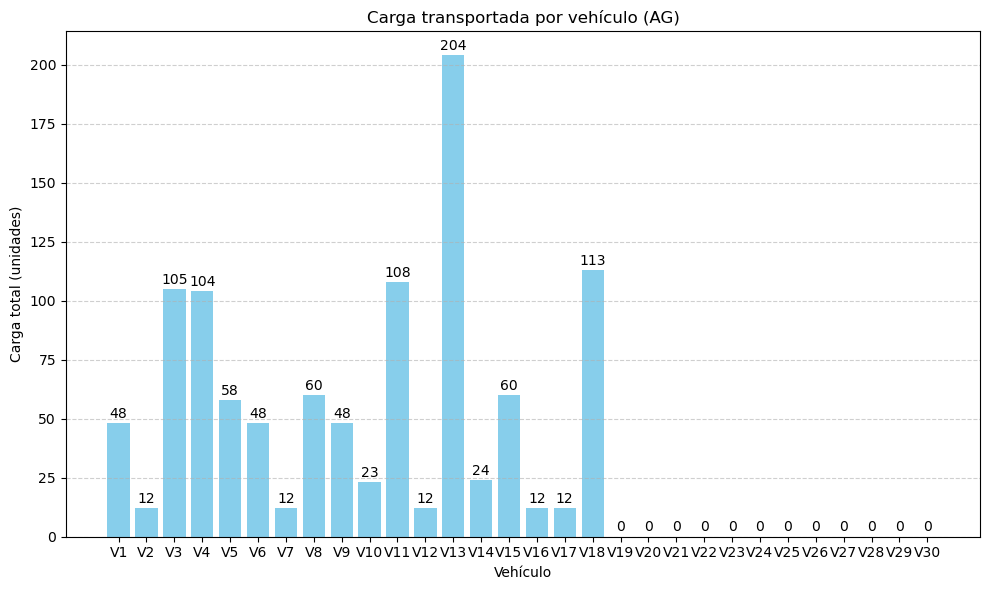

In [64]:
graficar_carga_por_vehiculo_ag(modelo_ag_3, nombre_figura="resultados/carga_por_vehiculo_ag_caso3.png")